# Section4 実装演習



## Flowers Recognitionデータセット前処理

参考URL
https://www.kaggle.com/simonritchie/flowers-recognition#%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%E6%95%B0%E7%A2%BA%E8%AA%8D

画像リサイズ仕様
- もし短辺が224pxを超過するようであれば、短辺が224pxになるように縮小する。
- 短辺が224px未満であれば、拡大は行わない。
- 画像の中央を基準に、224 x 224のサイズの画像としてペーストする。
    - 画像によっては上下もしくは左右が切り落とされる。
    - 小さい画像によっては、上下左右に白の余白が設定される。

訓練データのData augmentation
- 14000画像程度増やす
  - 左右反転で約+1150
  - 左方向に10度回転で+3100
  - 右方向に10度回転で+3100

In [21]:
# Flowers Recognitionデータセット前処理1: ファイル名/解像度/クラスラベル抽出
#  https://www.kaggle.com/simonritchie/flowers-recognition#%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%E6%95%B0%E7%A2%BA%E8%AA%8D

import os

import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageOps
from tqdm import tqdm

CLASS_NAME_LIST = []
DATASET_DIR_LIST = []

flowers_topdir = "work_section4/flowers/"
flowers_subdir = os.listdir(flowers_topdir)
for subdir in flowers_subdir:
    if os.path.isdir(flowers_topdir + subdir):
        CLASS_NAME_LIST.append(subdir)
        DATASET_DIR_LIST.append(flowers_topdir + subdir)

#print(DATASET_DIR_LIST[:5])

num_files = 0
overall_file_path_list = []
for dataset_dir in DATASET_DIR_LIST:
    listdir = os.listdir(dataset_dir)
    num_files += len(listdir)

    for file_name in listdir:
        file_path = dataset_dir + "/" + file_name
        overall_file_path_list.append(file_path)

print("num_files = ", num_files)
print(overall_file_path_list[:3])

file_path_list = []
file_name_list = []
width_list = []
height_list = []

for file_path in tqdm(overall_file_path_list):
    is_in = '.py' in file_path
    if is_in:
        continue
    is_in = '.pyc' in file_path
    if is_in:
        continue
    
    img = Image.open(file_path)
    width, height = img.size
    file_name = file_path.split('/')[-1]
    
    file_path_list.append(file_path)
    file_name_list.append(file_name)
    width_list.append(width)
    height_list.append(height)
    
    img.close()

def get_class_from_path(file_path):
    '''
    対象のファイルパスに応じた、クラスのラベルを取得する。
    '''
    for class_name in CLASS_NAME_LIST:
        is_in = class_name in file_path
        if is_in:
            return class_name
    raise ValueError('Invalid file path : %s' % file_path)


img_meta_df = pd.DataFrame(
    columns=['file_path', 'file_name', 'width', 'height', 'class'],
    index=np.arange(0, len(file_path_list)))

img_meta_df["file_path"] = file_path_list
img_meta_df["file_name"] = file_name_list
img_meta_df["width"] = width_list
img_meta_df["height"] = height_list
img_meta_df["class"] = img_meta_df["file_path"].apply(get_class_from_path)

print(img_meta_df[:3])


num_files =  4317
['work_section4/flowers/daisy/100080576_f52e8ee070_n.jpg', 'work_section4/flowers/daisy/10140303196_b88d3d6cec.jpg', 'work_section4/flowers/daisy/10172379554_b296050f82_n.jpg']


100%|██████████| 4317/4317 [00:01<00:00, 3670.65it/s]

                                           file_path  \
0  work_section4/flowers/daisy/100080576_f52e8ee0...   
1  work_section4/flowers/daisy/10140303196_b88d3d...   
2  work_section4/flowers/daisy/10172379554_b29605...   

                      file_name  width  height  class  
0    100080576_f52e8ee070_n.jpg    320     263  daisy  
1    10140303196_b88d3d6cec.jpg    500     313  daisy  
2  10172379554_b296050f82_n.jpg    320     215  daisy  


In [22]:
# Flowers Recognitionデータセット前処理2: 画像リサイズ
#  https://www.kaggle.com/simonritchie/flowers-recognition#%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%E6%95%B0%E7%A2%BA%E8%AA%8D

def convert_to_cropped_center_img(img, crop_width, crop_height):
    """
    指定された画像の中央部分を用いて、指定のサイズにトリミングを行う。
    """
    width, height = img.size
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    cropped_img = img.crop((left, top, right, bottom))
    return cropped_img

def save_reduced_size_img(file_path, file_name, dest_dir_path, dest_img_wh):
    """
    サイズを縮小した画像を保存する。
    """
    dest_file_path = dest_dir_path + file_name
    
    img = Image.open(file_path)
    width, height = img.size
    short_side_px = min(width, height)
    resize_ratio = short_side_px / IMG_SIZE
    resized_width = int(width / resize_ratio)
    resized_height = int(height / resize_ratio)
    resized_img = img.resize(
        size=(resized_width, resized_height), resample=Image.BILINEAR)
    
    cropped_img = convert_to_cropped_center_img(
        img=resized_img, crop_width=dest_img_wh, crop_height=dest_img_wh)
    cropped_img.save(fp=dest_file_path, quality=95)
    
    img.close()
    resized_img.close()
    cropped_img.close()
    return dest_file_path

def save_pasted_img(file_path, file_name, dest_dir_path, dest_img_wh):
    """
    指定のサイズの画像に貼り付けが必要な画像（保存サイズよりも短辺が
    短い画像）に対しての保存処理を行う。
    """
    dest_file_path = dest_dir_path + file_name
    
    canvas_img = Image.new(
        mode='RGB', size=(dest_img_wh, dest_img_wh), color='#ffffff')
    img = Image.open(file_path)
    width, height = img.size
    left = int(dest_img_wh / 2 - width / 2)
    top = int(dest_img_wh / 2 - height / 2)
    canvas_img.paste(img, box=(left, top))

    canvas_img.save(fp=dest_file_path, quality=95)
    img.close()
    canvas_img.close()
    return dest_file_path

IMG_SIZE = 224
#IMG_EXTENSION = 'jpg'
RESIZED_IMG_PATH = flowers_topdir + "../flowers_resized/"

reduced_size_img_path_list = []
pasted_img_path_list = []
overall_path_list = []

for index, sr in tqdm(img_meta_df.iterrows()):
    file_path = sr["file_path"]
    file_name = sr["file_name"]
    width = sr["width"]
    height = sr["height"]
    class_name = sr["class"]

    dest_dir = RESIZED_IMG_PATH + class_name + "/"
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    short_side_px = min(width, height)
    
    # 画像リサイズ＆保存
    if short_side_px > IMG_SIZE:
        saved_file_path = save_reduced_size_img(
            file_path, file_name, dest_dir, IMG_SIZE)
        reduced_size_img_path_list.append(saved_file_path)
    else:
        saved_file_path = save_pasted_img(
            file_path, file_name, dest_dir, IMG_SIZE)
        pasted_img_path_list.append(saved_file_path)
    
    overall_path_list.append(saved_file_path)

img_meta_df["resized_img_path"] = overall_path_list

img_meta_df.to_csv(flowers_topdir + "../flowers_dataset.csv")

4317it [00:21, 200.38it/s]


In [36]:
# Flowers Recognitionデータセット前処理3: Data Argumentation
#  https://www.kaggle.com/simonritchie/flowers-recognition#%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%E6%95%B0%E7%A2%BA%E8%AA%8D
import shutil
from copy import deepcopy

# ---------------------------
# 訓練データ／テストデータ分離
# ---------------------------
RANDOM_SEED = 42
shuffled_df = img_meta_df.sample(frac=1, random_state=RANDOM_SEED)
shuffled_df.drop_duplicates(subset=['file_name'], inplace=True)
shuffled_df.reset_index(drop=True, inplace=True)
TEST_DATA_NUM = 2000
TRAIN_DATA_NUM = len(shuffled_df) - TEST_DATA_NUM

train_df = shuffled_df[:TRAIN_DATA_NUM]
test_df = shuffled_df[TRAIN_DATA_NUM:]

TRAIN_IMG_DIR_PATH = flowers_topdir + "../train_img/"
TEST_IMG_DIR_PATH = flowers_topdir + "../test_img/"
if not os.path.exists(TRAIN_IMG_DIR_PATH):
    os.makedirs(TRAIN_IMG_DIR_PATH)
if not os.path.exists(TEST_IMG_DIR_PATH):
    os.makedirs(TEST_IMG_DIR_PATH)

for index, sr in train_df.iterrows():
    img_path = sr['resized_img_path']
    file_name = img_path.split('/')[-1]
    dest_path = TRAIN_IMG_DIR_PATH + file_name
    shutil.copy(src=img_path, dst=dest_path)

for index, sr in test_df.iterrows():
    img_path = sr['resized_img_path']
    file_name = img_path.split('/')[-1]
    dest_path = TEST_IMG_DIR_PATH + file_name
    shutil.copy(src=img_path, dst=dest_path)

# ---------------------------
# Data Argumentation
# ---------------------------

def save_mirrored_img(
        data_aug_list, source_file_path, train_data_dict,
        probability=0.5):
    """
    鏡像変換
    """
    random_val = np.random.random()
    if probability < random_val:
        return data_aug_list
    
    data_aug_meta_data_dict = deepcopy(train_data_dict)
    file_name = source_file_path.split('/')[-1]
    dir_path = source_file_path.replace(file_name, '')
    file_name_except_ext = file_name.split('.')[0]
    dest_file_path = dir_path + file_name_except_ext + "_mirrored.jpg"
    data_aug_meta_data_dict['resized_img_path'] = dest_file_path
    
    img = Image.open(fp=source_file_path)
    img = ImageOps.mirror(img)
    img.save(fp=dest_file_path, quality=95)
    img.close()
    
    data_aug_list.append(data_aug_meta_data_dict)
    return data_aug_list

def save_rotated_img(
        data_aug_list, source_file_path, train_data_dict, direction, img_size):
    """
    回転
    """
    data_aug_meta_data_dict = deepcopy(train_data_dict)
    file_name = source_file_path.split('/')[-1]
    dir_path = source_file_path.replace(file_name, '')
    file_name_except_ext = file_name.split('.')[0]
    dest_file_path = dir_path + file_name_except_ext + direction + ".jpg"
    data_aug_meta_data_dict['resized_img_path'] = dest_file_path
    
    img = Image.open(fp=source_file_path)
    rgba_img = img.convert('RGBA')
    background_img = Image.new(mode='RGBA', size=(img_size, img_size), color='white')
    if direction == "_left_rotation":
        angle = -10
    elif direction =="_right_rotation":
        angle = 10
    rotated_img = rgba_img.rotate(angle=angle, resample=Image.BICUBIC)
    composite_img = Image.composite(
        image1=rotated_img, image2=background_img, mask=rotated_img)
    composite_img = composite_img.convert('RGB')
    composite_img.save(fp=dest_file_path, quality=95)
    
    img.close()
    rgba_img.close()
    background_img.close()
    rotated_img.close()
    composite_img.close()
    
    data_aug_list.append(data_aug_meta_data_dict)
    return data_aug_list

# 鏡像変換
train_data_list = train_df.to_dict(orient='record')

data_aug_meta_data_list = []
for train_data_dict in tqdm(train_data_list):
    data_aug_meta_data_list = save_mirrored_img(
        data_aug_meta_data_list,
        train_data_dict["resized_img_path"],
        train_data_dict)

train_data_list.extend(data_aug_meta_data_list)

# 回転
data_aug_meta_data_list = []
for train_data_dict in tqdm(train_data_list):
    data_aug_meta_data_list = save_rotated_img(
        data_aug_meta_data_list,
        train_data_dict["resized_img_path"],
        train_data_dict,
        "_left_rotation", IMG_SIZE)
    
    data_aug_meta_data_list = save_rotated_img(
        data_aug_meta_data_list,
        train_data_dict["resized_img_path"],
        train_data_dict,
        "_right_rotation", IMG_SIZE)

train_data_list.extend(data_aug_meta_data_list)

data_aug_train_df = pd.DataFrame(train_data_list)
shuffled_train_df = data_aug_train_df.sample(frac=1, random_state=RANDOM_SEED)
sliced_train_df = shuffled_train_df.loc[:, ["class", "resized_img_path"]]
sliced_train_df.rename(columns={"resized_img_path": "img_path"}, inplace=True)
sliced_train_df.to_csv(flowers_topdir + "../flowers_dataset_train.csv", index=False)


C:\Users\shima\AppData\Local\Temp/ipykernel_18524/811969067.py:102: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  train_data_list = train_df.to_dict(orient='record')
100%|██████████| 3491/3491 [00:52<00:00, 66.25it/s]


{'file_path': 'work_section4/flowers/tulip/21055041762_5d0a066948_n.jpg', 'file_name': '21055041762_5d0a066948_n.jpg', 'width': 240, 'height': 134, 'class': 'tulip', 'resized_img_path': 'work_section4/flowers/../flowers_resized/tulip/21055041762_5d0a066948_n_left_rotation.jpg'}


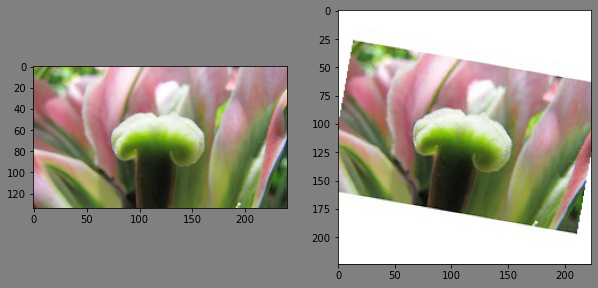

In [37]:
# 確認用
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(data_aug_meta_data_list[0])

plt.figure(facecolor="gray", figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(mpimg.imread(data_aug_meta_data_list[0]["file_path"]))
plt.subplot(1,2,2)
plt.imshow(mpimg.imread(data_aug_meta_data_list[0]["resized_img_path"]))


In [38]:
# Flowers Recognitionデータセット前処理4: 画像のnumpy配列化
#  https://www.kaggle.com/simonritchie/flowers-recognition#%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88%E6%95%B0%E7%A2%BA%E8%AA%8D

def set_img_arr_to_mm_arr(numpy_mm, img_path, index):
    """
    対象のmemmap配列に、対象の画像の配列の値を設定する。
    """
    img = Image.open(fp=img_path)
    np_array = np.array(img)
    np_array = np_array.astype(np.float16, copy=False)
    np_array /= 255
    numpy_mm[index] = np_array
    img.close()
    del np_array
    return

# 訓練画像の配列化
X_train_mm_path = flowers_topdir + "../X_train.npy"
X_test_mm_path = flowers_topdir + "../X_test.npy"

X_train_mm = np.memmap(
    X_train_mm_path, dtype=np.float16, mode='w+',
    shape=(len(sliced_train_df), IMG_SIZE, IMG_SIZE, 3))

sliced_train_df.reset_index(drop=True, inplace=True)

for index, sr in tqdm(sliced_train_df.iterrows()):
    img_path = sr['img_path']
    set_img_arr_to_mm_arr(X_train_mm, img_path, index)

# テスト画像の配列化
sliced_test_df = test_df.loc[:, ['class', 'resized_img_path']]
sliced_test_df.rename(columns={'resized_img_path': 'img_path'}, inplace=True)
sliced_test_df.to_csv(flowers_topdir + "../flowers_dataset_test.csv", index=False)
X_test_mm = np.memmap(
    filename=X_test_mm_path, dtype=np.float16, mode='w+',
    shape=(len(sliced_test_df), IMG_SIZE, IMG_SIZE, 3))

sliced_test_df.reset_index(drop=True, inplace=True)

for index, sr in tqdm(sliced_test_df.iterrows()):
    img_path = sr['img_path']
    set_img_arr_to_mm_arr(X_test_mm, img_path,index)

10473it [00:30, 346.33it/s]
2000it [00:05, 348.74it/s]


## モデル試行

https://qiita.com/simonritchie/items/f6d6196b1b0c41ca163c


In [1]:
# データロード
# https://qiita.com/simonritchie/items/f6d6196b1b0c41ca163c

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.utils import np_utils

# データロード
flowers_topdir = "work_section4/flowers/"
train_meta_df = pd.read_csv(flowers_topdir + "../flowers_dataset_train.csv")
test_meta_df = pd.read_csv(flowers_topdir + "../flowers_dataset_test.csv")

NUM_TRAIN = len(train_meta_df)
NUM_TEST = len(test_meta_df)
IMG_SIZE = 224
NUM_BATCH = 128
NUM_EPOCH = 40

X_train = np.memmap(
    filename=flowers_topdir + "../X_train.npy", dtype=np.float16, 
    mode='r', shape=(NUM_TRAIN, IMG_SIZE, IMG_SIZE, 3) )
y_train = train_meta_df['class'].values

le = preprocessing.LabelEncoder()
le.fit(y_train)
NUM_CLASSES = len(le.classes_)
y_train = le.transform(y_train)
y_train = np_utils.to_categorical(y=y_train, num_classes=NUM_CLASSES)

X_test = np.memmap(
    filename=flowers_topdir + "../X_test.npy", dtype=np.float16, 
    mode='r', shape=(NUM_TEST, IMG_SIZE, IMG_SIZE, 3))
y_test = test_meta_df['class'].values
y_test = le.transform(y_test)
y_test = np_utils.to_categorical(y=y_test, num_classes=NUM_CLASSES)


Epoch 1/40
82/82 - 254s - loss: 1.2685 - accuracy: 0.4706 - val_loss: 1.6084 - val_accuracy: 0.1765 - 254s/epoch - 3s/step
Epoch 2/40
82/82 - 260s - loss: 0.9894 - accuracy: 0.6057 - val_loss: 1.6069 - val_accuracy: 0.2305 - 260s/epoch - 3s/step
Epoch 3/40
82/82 - 260s - loss: 0.8222 - accuracy: 0.6850 - val_loss: 1.6043 - val_accuracy: 0.2305 - 260s/epoch - 3s/step
Epoch 4/40
82/82 - 260s - loss: 0.7039 - accuracy: 0.7328 - val_loss: 1.6024 - val_accuracy: 0.2305 - 260s/epoch - 3s/step
Epoch 5/40
82/82 - 260s - loss: 0.6103 - accuracy: 0.7701 - val_loss: 1.6051 - val_accuracy: 0.2305 - 260s/epoch - 3s/step
Epoch 6/40
82/82 - 262s - loss: 0.5089 - accuracy: 0.8114 - val_loss: 1.6176 - val_accuracy: 0.2305 - 262s/epoch - 3s/step
Epoch 7/40
82/82 - 258s - loss: 0.4320 - accuracy: 0.8364 - val_loss: 1.6284 - val_accuracy: 0.2305 - 258s/epoch - 3s/step
Epoch 8/40
82/82 - 253s - loss: 0.3841 - accuracy: 0.8609 - val_loss: 1.6776 - val_accuracy: 0.2305 - 253s/epoch - 3s/step
Epoch 9/40
82/82

C:\Users\shima\anaconda3\envs\studyai\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


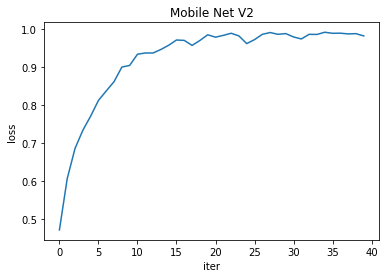

In [7]:
# モデル作成：MobileNetV2
# https://qiita.com/simonritchie/items/f6d6196b1b0c41ca163c

from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam

model_mnv2 = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=0.5, weights=None,
    classes=NUM_CLASSES)
model_mnv2.compile(
    loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])

hist = model_mnv2.fit(
    x=X_train, y=y_train, batch_size=NUM_BATCH, epochs=NUM_EPOCH, 
    verbose=2, validation_data=(X_test, y_test))

model_mnv2.summary()
model_mnv2.save(filepath=flowers_topdir+"../model_flowers_mobilenetv2.h5")


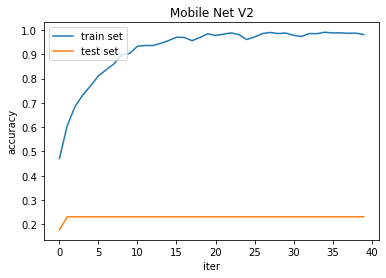

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(facecolor="white")
plt.title("Mobile Net V2")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.plot(hist.history["accuracy"],label="train set")
plt.plot(hist.history["val_accuracy"],label="test set")
#plt.plot(hist.history["loss"],label="train set")
#plt.plot(hist.history["val_loss"],label="test set")
plt.legend(loc='upper left')
plt.show()

Epoch 1/40
82/82 [==============================] - 2339s 29s/step - loss: 1.6618 - accuracy: 0.2440 - val_loss: 1.6015 - val_accuracy: 0.2305
Epoch 2/40
82/82 [==============================] - 2331s 28s/step - loss: 1.5975 - accuracy: 0.2529 - val_loss: 1.6026 - val_accuracy: 0.2305
Epoch 3/40
82/82 [==============================] - 2343s 29s/step - loss: 1.5974 - accuracy: 0.2529 - val_loss: 1.6015 - val_accuracy: 0.2305
Epoch 4/40
82/82 [==============================] - 2330s 28s/step - loss: 1.5973 - accuracy: 0.2529 - val_loss: 1.6015 - val_accuracy: 0.2305
Epoch 5/40
82/82 [==============================] - 2335s 28s/step - loss: 1.5971 - accuracy: 0.2529 - val_loss: 1.6033 - val_accuracy: 0.2305
Epoch 6/40
82/82 [==============================] - 2286s 28s/step - loss: 1.5971 - accuracy: 0.2529 - val_loss: 1.6033 - val_accuracy: 0.2305
Epoch 7/40
82/82 [==============================] - 2279s 28s/step - loss: 1.5975 - accuracy: 0.2529 - val_loss: 1.6023 - val_accuracy: 0.2305

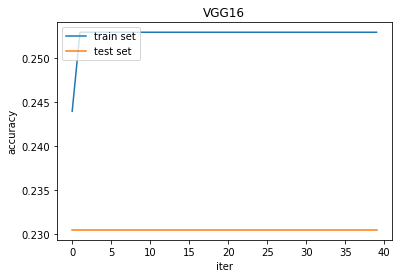

In [16]:
# モデル作成：VGG16
# https://qiita.com/simonritchie/items/f6d6196b1b0c41ca163c

from keras.applications.vgg16 import VGG16

model_vgg16 = VGG16(
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classes=NUM_CLASSES)

model_vgg16.compile(
    loss='categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])

hist_vgg16 = model_vgg16.fit(
    x=X_train, y=y_train, batch_size=NUM_BATCH, epochs=NUM_EPOCH, 
    verbose=1, validation_data=(X_test, y_test))

model_vgg16.summary()
model_vgg16.save(filepath=flowers_topdir+"../model_flowers_vgg16.h5")

plt.figure(facecolor="white")
plt.title("VGG16")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.plot(hist_vgg16.history["accuracy"],label="train set")
plt.plot(hist_vgg16.history["val_accuracy"],label="test set")
#plt.plot(hist_vgg16.history["loss"],label="train set")
#plt.plot(hist_vgg16.history["val_loss"],label="test set")
plt.legend(loc='upper left')
plt.show()
